# 读取 UCI  Buzz in social media 数据集，使用 k-最近邻算法进行缺失值填充，计算自变量（各属性）的填充性能，进行RMSE分析
海量数据文件，高维数据，优化代码
2023年6月22日

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml

import missingno as msno

from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import BallTree

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import random
from scipy.stats import entropy



import time

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
rmse = lambda y, yhat: np.sqrt(mean_squared_error(y, yhat))

In [ ]:
"Buzz in social media"数据集是一个包含Twitter上话题的数据集，其中包含有关每个话题的元数据和文本内容。
该数据集是由谢菲尔德大学的研究人员创建的，用于研究社交媒体上的话题和趋势。

该数据集包含了2013年10月至2015年9月期间的大量推文，涵盖了各种话题，包括政治、娱乐、体育、科技和社会事件等。
数据集中的每个推文都包括作者、推文内容、日期和时间戳、推文ID、转发和收藏数以及其他有关推文的元数据。

该数据集可以用于进行社交媒体分析、话题建模、情感分析、事件检测等研究。如果您有兴趣使用该数据集，
可以在谢菲尔德大学的网站上找到更多信息和下载链接。
每个推文由10个属性特征组成，包括Tweet ID、Date、Time、Day of Week、Message、User ID、Follower Count、Friend Count、Retweet Count和Favorite Count。
具体特征描述如下：
    Tweet ID：推文的唯一标识符。
    Date：推文发布的日期。
    Time：推文发布的时间。
    Day of Week：推文发布的星期几。
    Message：推文的文本内容。
    User ID：发布推文的用户的唯一标识符。
    Follower Count：发布推文的用户的粉丝数。
    Friend Count：发布推文的用户的关注数。
    Retweet Count：推文被转发的次数。
    Favorite Count：推文被收藏的次数。

In [2]:
# 读取数据集
#column_names = ["Tweet ID", "Date", "Time", "Day of Week", "Message", "User ID", "Follower Count", "Friend Count", "Retweet Count", "Favorite Count"]
buzz_df = pd.read_csv('Twitter.data',header=None)  #,,names=column_names,sep = ',' , sep='\s+' ,  names=column_names, "\t" '\s+'\s+ ,nrows=100, usecols=range(10000)
#dermatology_df_csv = pd.read_csv('dermatologydata.csv',header=None) #,names=column_names,sep = ','
"""
header=0 : 表示CSV文件第一行是列名,将第一个行作为列名读取
header=1 : 表示CSV文件的第二行是列名,将第二行作为列名读取,跳过第一个行
header=None : 表示CSV文件没有列名行,将默认的'col1','col2'等作为列名
"""

"\nheader=0 : 表示CSV文件第一行是列名,将第一个行作为列名读取\nheader=1 : 表示CSV文件的第二行是列名,将第二行作为列名读取,跳过第一个行\nheader=None : 表示CSV文件没有列名行,将默认的'col1','col2'等作为列名\n"

In [3]:
buzz_df

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,0,2,0,0,1,1,1,0,1,0,...,1.000000,1.000000,0,2,0,0,1,1,1,0.0
1,2,1,0,0,0,0,4,2,1,0,...,0.000000,1.000000,2,1,0,0,0,0,4,0.5
2,1,0,0,0,0,4,1,1,0,0,...,1.000000,1.000000,1,0,0,0,0,4,1,0.0
3,1,0,0,1,0,0,1,1,0,0,...,0.000000,1.000000,1,0,0,1,0,0,1,2.5
4,0,1,0,0,1,2,3,0,1,0,...,1.000000,1.000000,0,1,0,0,1,2,3,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583245,1289,1228,1343,1999,1789,1643,1626,582,487,506,...,1.143549,1.185776,1300,1240,1352,2006,1797,1651,1631,2120.0
583246,1228,1343,1999,1789,1643,1626,2582,487,506,752,...,1.185776,1.217879,1240,1352,2006,1797,1651,1631,2584,1490.0
583247,1343,1999,1789,1643,1626,2582,1649,506,752,663,...,1.217879,1.230072,1352,2006,1797,1651,1631,2584,1656,1407.5
583248,1689,1468,0,1721,1699,1565,1688,618,610,0,...,1.129936,1.100945,1702,1478,0,1722,1702,1570,1694,1465.5


In [ ]:
具体流程是:
#0. 将数据集中 ID列删除，把Class列数值化
1. 读取数据到buzz_df,拷贝原始真实值为buzz_df_origin
2. 将buzz_df划分为train_df和test_df,拷贝原始真实值为train_df_origin和test_df_origin
3. 随机在train_df和test_df中产生10%的缺失值
4. 使用KNN在X_train中填充缺失值,并fit knn_imputer模型，调整K值 
5. 使用knn_imputer在X_test_scaled中填充缺失值 
6. 计算填充后test_imputed与标准化后真实值test_df_origin的MSE

In [4]:
buzz_df.isna().sum()

0     0
1     0
2     0
3     0
4     0
     ..
73    0
74    0
75    0
76    0
77    0
Length: 78, dtype: int64

In [8]:
#1. 将数据集划分为训练集和测试集
#random_state 的取值通常为整数,不同的整数会产生不同的随机结果,而相同的整数会产生相同的随机结果,实现可重复性
train_df, test_df = train_test_split(buzz_df,test_size=0.2,random_state=24)


In [9]:
train_df_origin = train_df.copy()
test_df_origin = test_df.copy()

In [33]:
#对同一训练集和测试集，重复多次实验，运行以下代码
#train_df = train_df_origin.copy()
#test_df = test_df_origin.copy()

In [10]:
%%time
# 2. 在训练集中随机产生10%的数据缺失
missing_rate = 0.1
np.random.seed(1) 
ixt = [(row, col) for row in range(train_df.shape[0]) for col in range(train_df.shape[1])]

for row, col in random.sample(ixt, int(round(missing_rate*len(ixt)))):
    train_df.iat[row, col] = np.nan

Wall time: 1min 19s


In [11]:

# Calculate the missing value distribution每列分别找出包含缺失值的行的位置，然后将所有列的缺失值的行位置合并到一个列表中，得到了缺失值的分布。
#然后，我们使用 np.bincount 函数计算了每个行位置出现的次数，然后除以总的缺失值数量，得到了每个行位置的比例，这就是缺失值的分布。最后，我们使用 scipy.stats.entropy 函数计算了这个分布的熵。
missing_values_distribution = []
for col in train_df.columns:
    missing_row_positions = train_df[train_df[col].isnull()].index.tolist()
    missing_values_distribution.extend(missing_row_positions)

# Convert the distribution to proportions
#missing_values_distribution = np.array(missing_values_distribution)
missing_values_distribution = np.array(missing_values_distribution).astype(int)
missing_values_proportions = np.bincount(missing_values_distribution) / len(missing_values_distribution)

# Calculate the entropy of the missing value distribution
missing_values_entropy = entropy(missing_values_proportions)

print(f'The entropy of the missing value distribution in the train set is {missing_values_entropy}')

The entropy of the missing value distribution in the train set is 12.99373912962065


<AxesSubplot:>

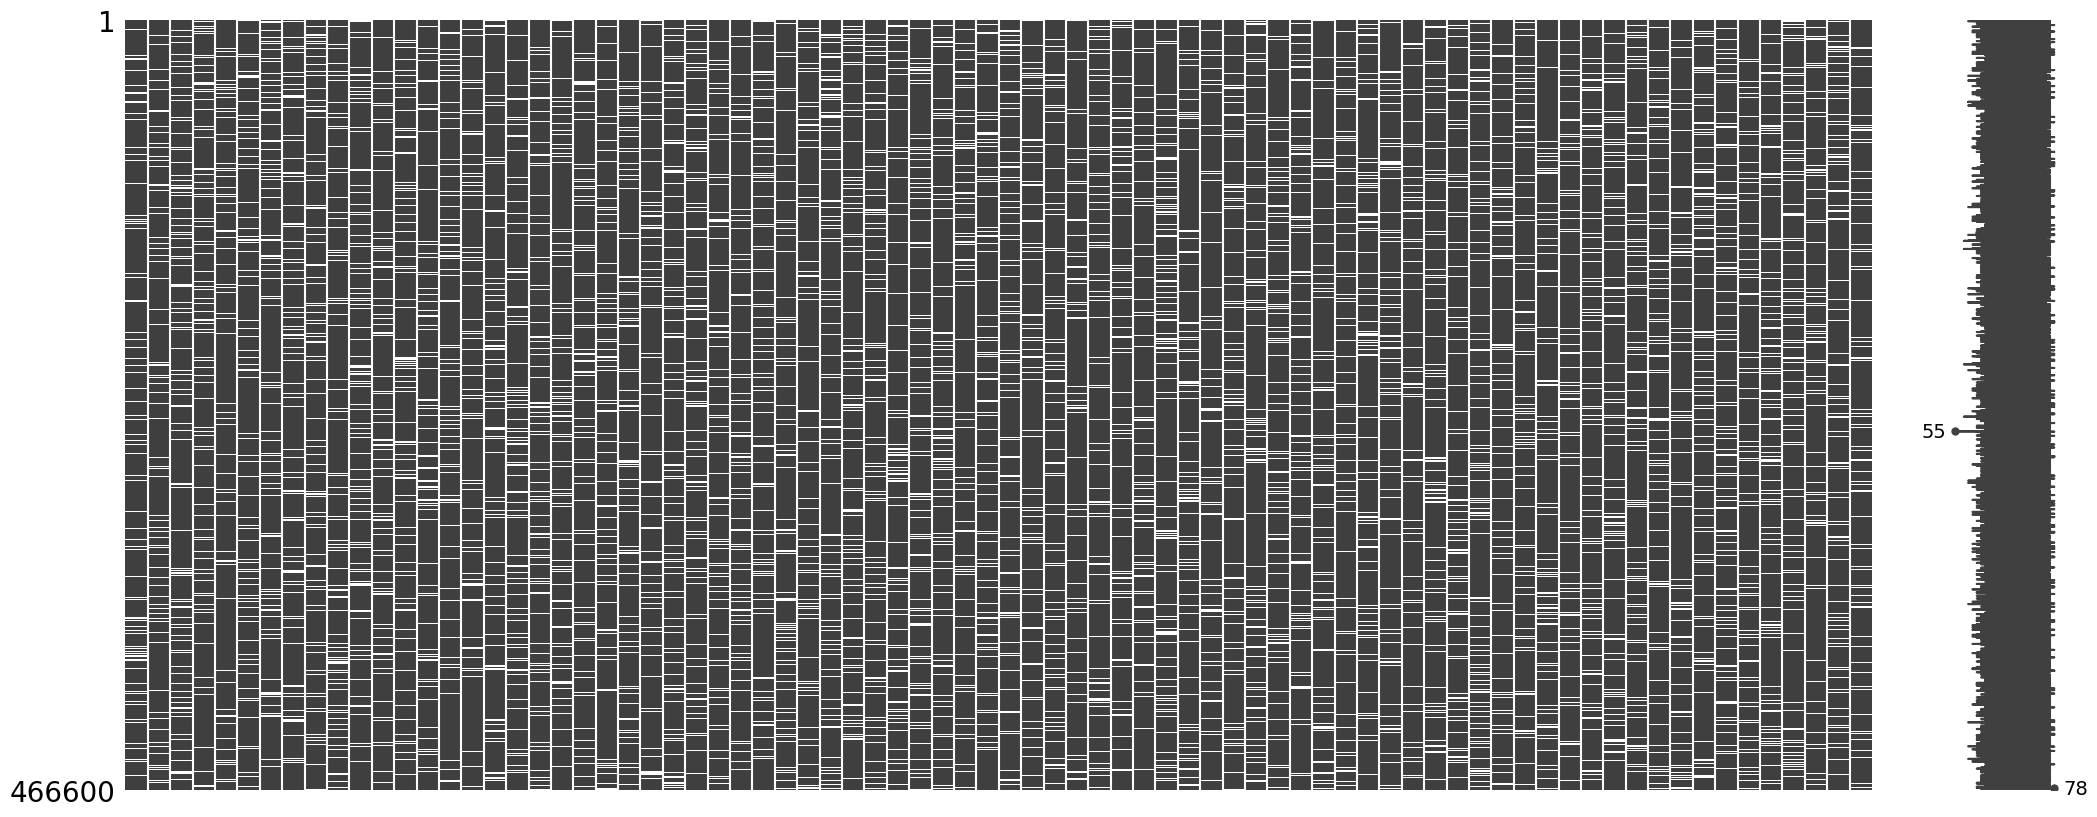

In [9]:
# 可视化缺失值
msno.matrix(train_df)

In [11]:
%%time
# 3. 在测试集中随机产生10%的数据缺失
#import time
np.random.seed(0) 
#np.random.seed(int(time.time()))  # Use current timestamp as random seed
missing_rate = 0.1
ixtest = [(row2, col2) for row2 in range(test_df.shape[0]) for col2 in range(test_df.shape[1])]
for row2, col2 in random.sample(ixtest, int(round(missing_rate*len(ixtest)))):
    test_df.iat[row2, col2] = np.nan

Wall time: 19.3 s


In [12]:
# Calculate the missing value distribution每列分别找出包含缺失值的行的位置，然后将所有列的缺失值的行位置合并到一个列表中，得到了缺失值的分布。
#然后，我们使用 np.bincount 函数计算了每个行位置出现的次数，然后除以总的缺失值数量，得到了每个行位置的比例，这就是缺失值的分布。最后，我们使用 scipy.stats.entropy 函数计算了这个分布的熵。
missing_values_distribution = []
for col in test_df.columns:
    missing_row_positions = test_df[test_df[col].isnull()].index.tolist()
    missing_values_distribution.extend(missing_row_positions)

# Convert the distribution to proportions
#missing_values_distribution = np.array(missing_values_distribution)
missing_values_distribution = np.array(missing_values_distribution).astype(int)
missing_values_proportions = np.bincount(missing_values_distribution) / len(missing_values_distribution)

# Calculate the entropy of the missing value distribution
missing_values_entropy = entropy(missing_values_proportions)

print(f'The entropy of the missing value distribution in the test set is {missing_values_entropy}')

The entropy of the missing value distribution in the test set is 11.607241890665343


<AxesSubplot:>

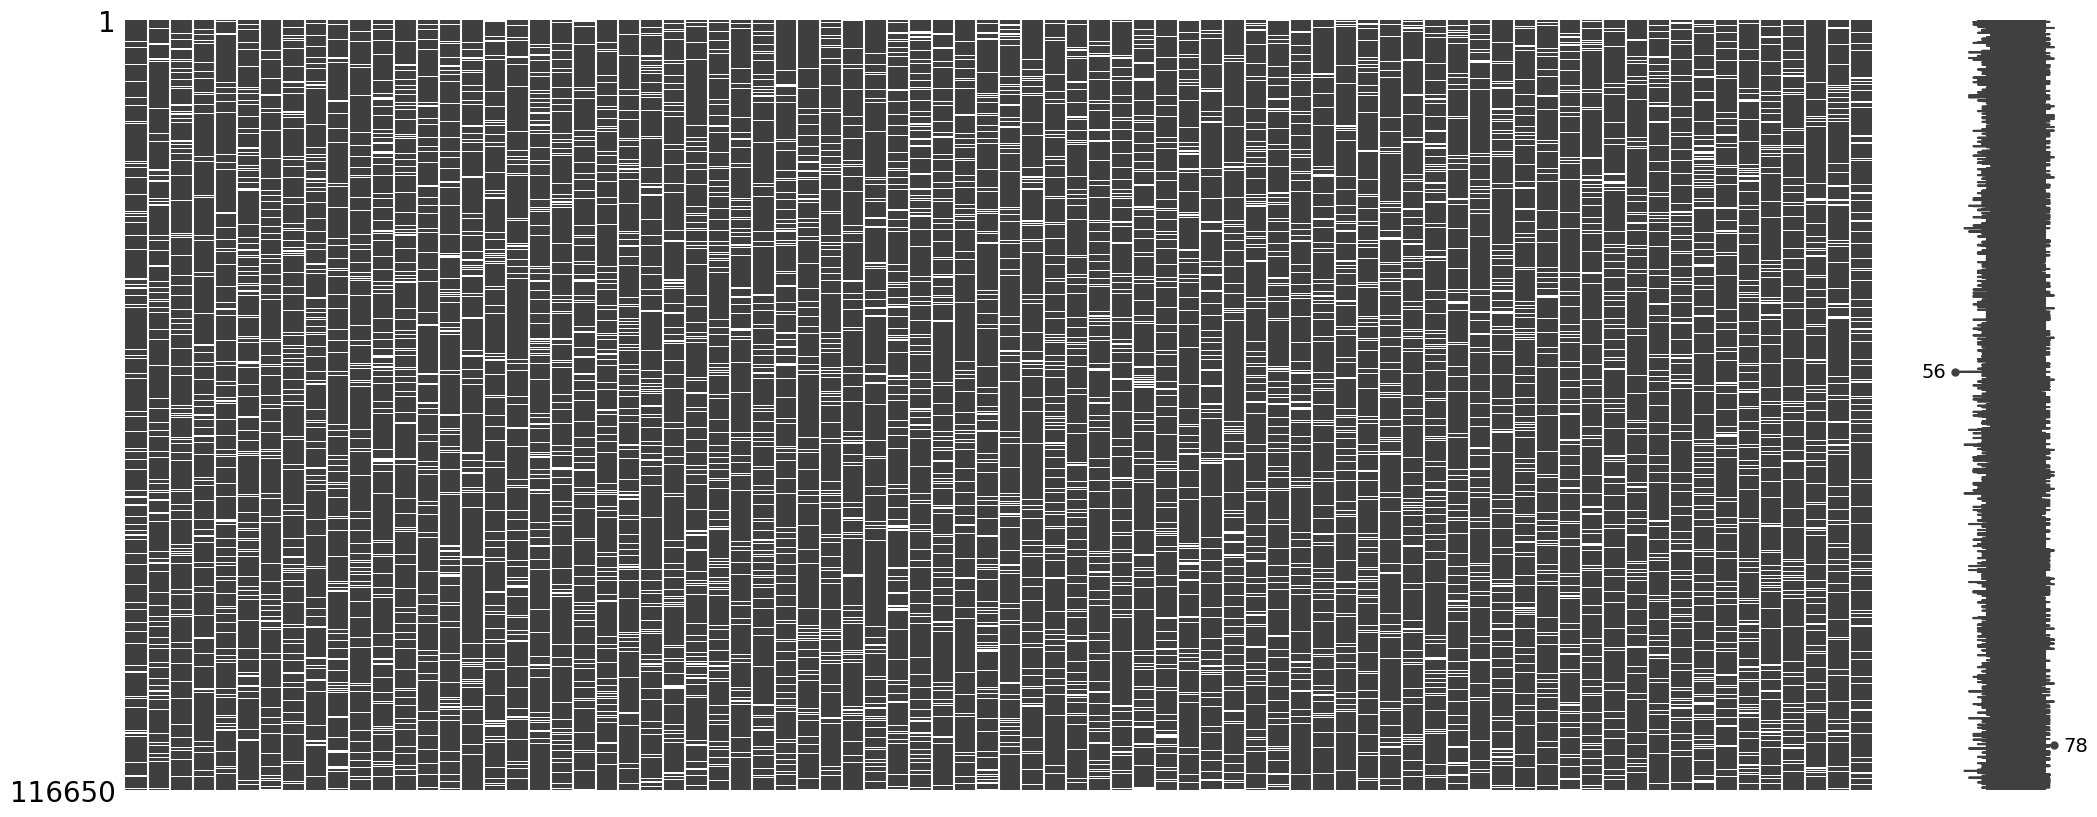

In [14]:
# 可视化缺失值
msno.matrix(test_df)

In [ ]:
  #计算自变量X的填充性能RMSE 
k_values = []
X_rmse_values=[]
X_rmse_mean=[]
for k in range(1, 20,1):
    imputer = KNNImputer(n_neighbors=k, weights="uniform")
    train_filled = imputer.fit_transform(train_df)
    test_filled = imputer.transform(test_df)
# 将结果重新转换为数据框
    train_filled = pd.DataFrame(train_filled, columns = train_df.columns)
    test_filled = pd.DataFrame(test_filled, columns = test_df.columns)
# 5. 评估填充效果，即测试集的填充值与真实值的MSE（这里我们拥有原始未缺失数据test_df_origin）
    #mse_train = mean_squared_error(train_df_origin, train_filled)
    mse_test = mean_squared_error(test_df_origin, test_filled, multioutput='raw_values')
    mse_mean = np.mean(mse_test)
 #计算填充性能RMSE 
    #print(f'Train MSE: {mse_train}')
    print(f'k=: {k}')
    print(f'Test MSE: {mse_test}')
    print(f'Test mean MSE: {mse_mean}')
    k_values.append(k)
    X_rmse_values.append(np.sqrt(mse_test))
    X_rmse_mean.append(np.sqrt(mse_mean))

k=: 1
Test MSE: [4.54471384e+02 3.87697445e+02 4.75204166e+02 6.68679434e+02
 5.15297085e+02 1.53450707e+03 7.46035654e+02 2.58233811e+02
 2.95707184e+02 3.11017111e+02 4.35612456e+02 4.12391222e+02
 6.78503429e+02 7.35578345e+02 5.62233398e-09 5.41892628e-09
 6.11206423e-09 6.78370890e-09 8.97417372e-09 8.21103451e-09
 8.38823536e-09 1.77135912e-03 2.38844704e-03 1.67148137e-03
 1.80733293e-03 1.36677539e-03 9.61233988e-04 9.04114633e-04
 4.28703583e+02 4.86663283e+02 5.45827278e+02 9.75117814e+02
 1.90560632e+03 1.09603289e+03 1.43944518e+03 1.99559931e-09
 1.95338134e-09 2.21261061e-09 2.01692816e-09 2.95727416e-09
 3.35118627e-09 3.92044667e-09 1.74024861e-03 1.78311187e-03
 1.81740249e-03 1.53450493e-03 1.24303472e-03 7.54393485e-04
 8.74410630e-04 2.06848966e-01 3.12407709e-01 4.83545385e-01
 3.81186968e-01 3.34655445e-01 2.89607206e-01 9.22262602e-02
 3.11942297e+02 3.64707484e+02 4.01512130e+02 4.27436785e+02
 7.49033982e+02 1.55180225e+03 2.28698345e+03 1.02039758e-01
 5.30596

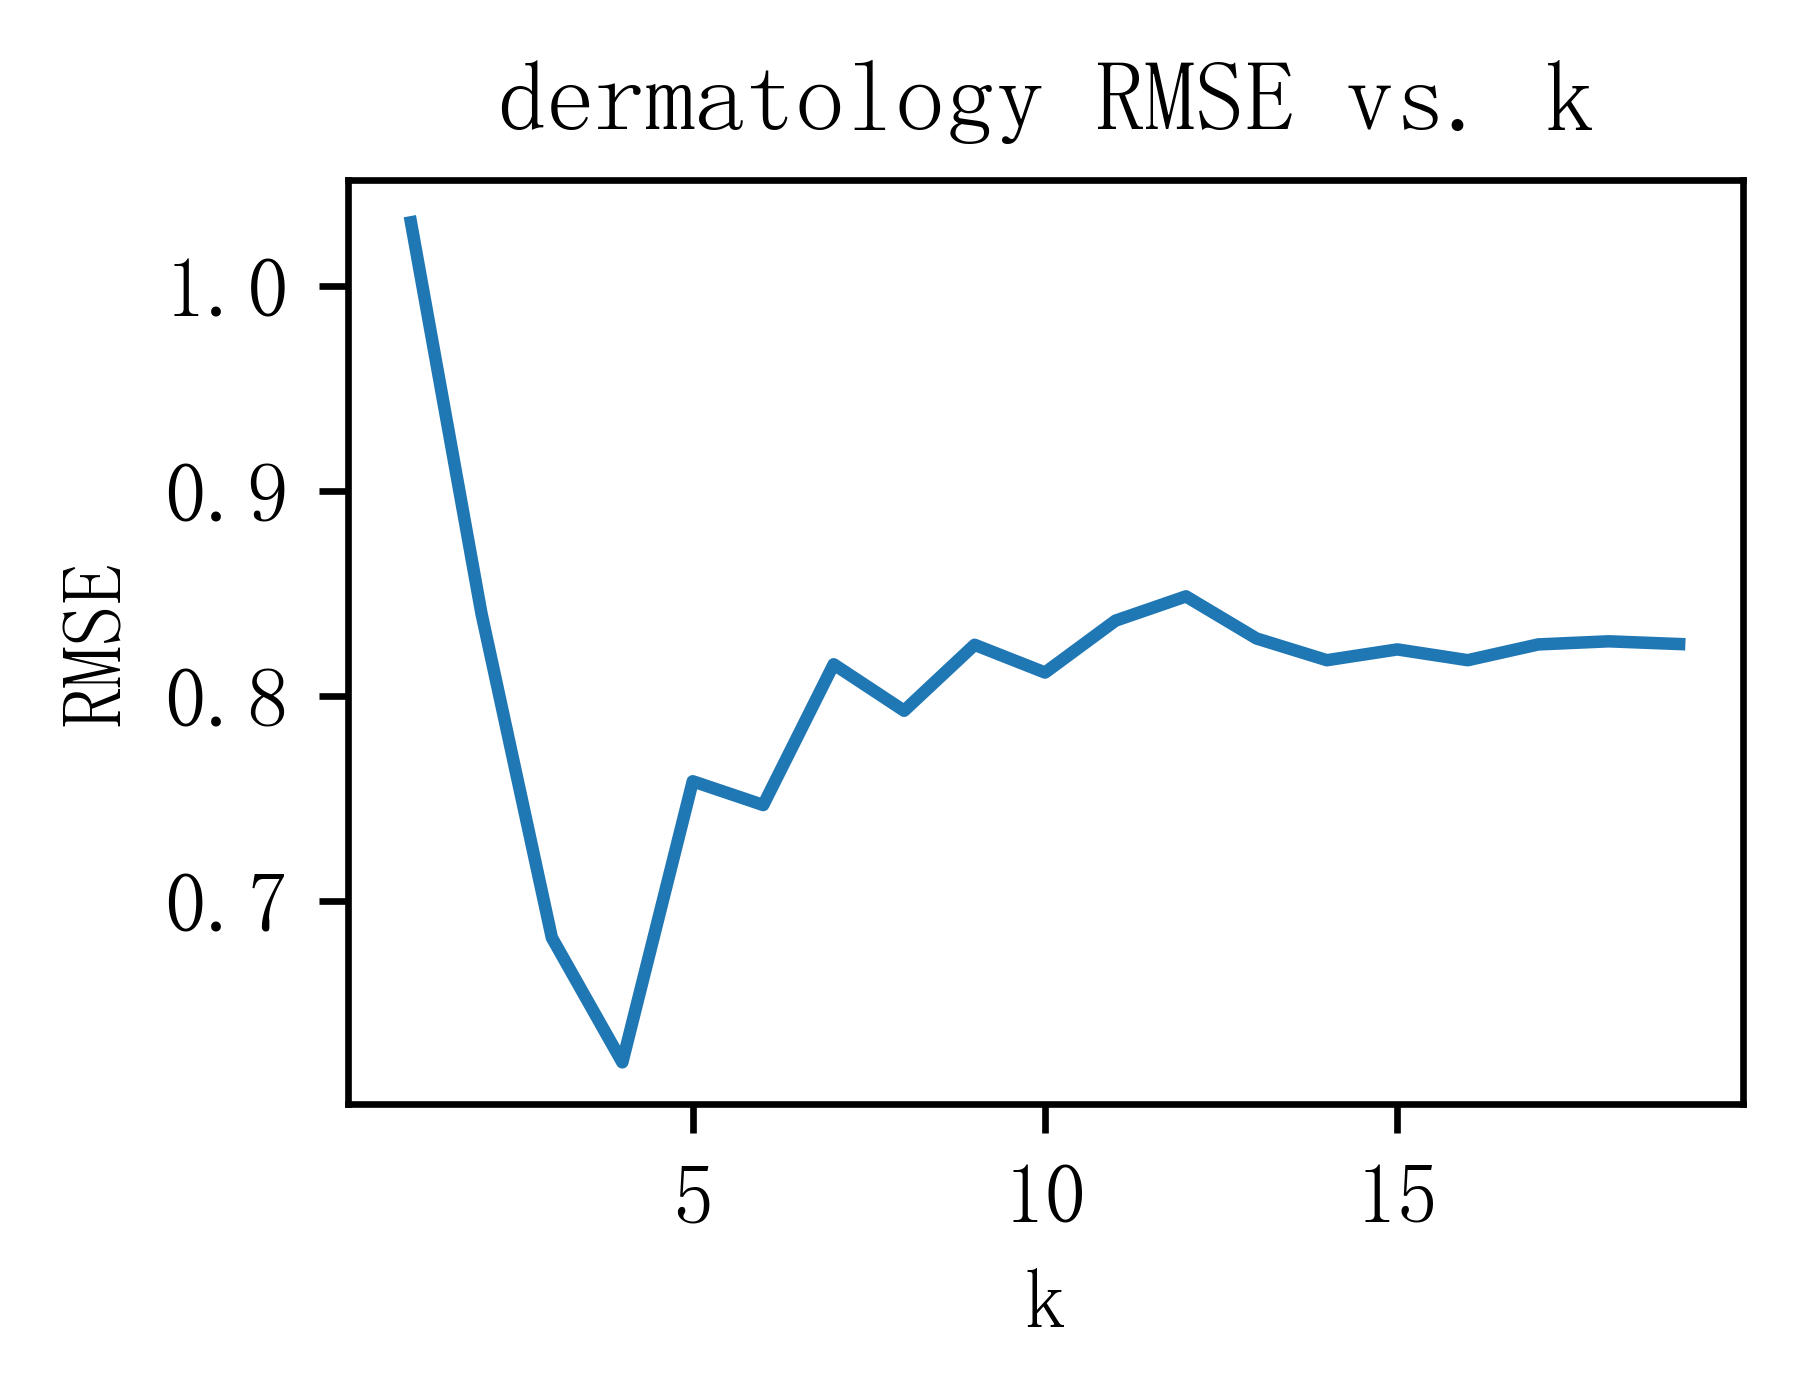

In [39]:
# 设置图像尺寸和分辨率
fig = plt.figure(figsize=(3, 2), dpi=600)

# 设置字体
plt.rcParams['font.sans-serif'] = ['SimSun']  # 设置宋体
plt.rcParams['font.serif'] = ['Times New Roman']  # 设置新罗马
plt.rcParams['font.size'] = 10  # 设置字号为10pt

# 生成 k 值和均方根误差
#k_values = range(1, 21)
#rmse_values = np.random.rand(20) * 10  # 生成随机均方根误差

# 绘制图像
plt.plot(k_values, X_rmse_mean)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.title('Buzz RMSE vs. k')

# 保存图像
plt.savefig('k_rmse_knn_RF.tiff')

In [40]:
# 首先，我们需要将这三个数组堆叠在一起以形成一个新数组
merged_array = np.column_stack((k_values, X_rmse_values, X_rmse_mean))
# 接着，我们将这个数组转换为 Pandas DataFrame
df = pd.DataFrame(merged_array)
# 最后，我们可以将这个 DataFrame 输出到 CSV 文件中
df.to_csv('buzzKNN_K.csv', index=False)  #index=False 表示在输出的 CSV 文件中不包含索引列